In [ ]:
import string

In [ ]:
"""
We want to extract a canonical instrument name from the title.
What are some characteristics of musical instrument names?
"""
open("subjects.txt", "r").readlines()

In [ ]:
"""
We can tag the words in the subject by:

* Type (what kind of instrument is it?)
* Attribute (what distinguishes the instrument within its type? e.g: material, use case)
* Brand (who manufactures it?)
* Model (which product is it?)
* Variant (what are the variable properties of the instrument?)
  * Date of manufacture
  * Color
  * Size
  * Condition
  * Quantity e.g in speakers

We can exploit the fact that models frequently imply brands e.g:

* Push 2 -> Ableton
* MPC -> Akai

However we should be careful with this as there could be overlap
between model names, particularly short abbreviated names.

(add example)

Do brands imply type? Not absolutely however perhaps with
some frequency on real data (e.g if someone is selling something
by Dean its most likely to be a Guitar, not a Ukulele).

Thinking out loud about some more categories:

* Series, like Roland MC-* - usually part of the Model

We note that there are a few classes of sentences:

* Sale of a model of item e.g P90 Telecaster
* Sales of a type of item e.g Electric Weighted Keyboard
* Sale of a lot of items with variable type e.g Studio Blowout
* Sale of a lot of items with a fixed type e.g Guitar Pedals
* Things that don't belong in msa (services, items wanted)
"""

In [ ]:
"""
Let's manually tag a random sample of 1000 with TYPE, BRAND, MODEL & VARIANT.
gshuf < subjects.txt | head -n 1000 > training-subjects.txt
"""
training_subjects = open("training-subjects.txt", "r").readlines()

def clean_subject(subject):
    # Remove price / location info if present
    # XXX There is a bug here if the subject contains " - " and no price / location
    SEPARATOR = " - "
    if SEPARATOR in subject:
        subject = " ".join(subject.split(SEPARATOR)[:-1])
        
    # Replace special characters with whitespace
    subject = subject.translate(str.maketrans(dict(zip(string.punctuation, " " * len(string.punctuation)))))
    
    # Remove redundant whitespace
    subject = " ".join(subject.split())
    
    return f"{subject}\n"
        
clean_training_subjects = [
    clean_subject(subject)
    for subject in training_subjects
]

with open("clean-training-subjects.txt", "w") as outfile:
    outfile.writelines(clean_training_subjects)

In [ ]:
"""
What are some properties that we can intuitively infer from the tagged corpora?

* BRAND tends to be the first word in the subject
* The word "condition" tends to come after the value of a VARIANT
* The word "version" tends to come before the value of a VARIANT
* TYPEs can play as ATTRIBUTEs e.g Rare/ATTRIBUTE Hiwatt/BRAND Pre_1/MODEL Bass_Guitar/ATTRIBUTE Pre_Amp/TYPE
* The word "vintage" can play as a VARIANT or ATTRIBUTE - it is really useless for classification tho
* Tricky to distinguish "thing with case" from "thing case" e.g Srunal/BRAND 260/MODEL 4_4/ATTRIBUTE Beginner/ATTRIBUTE violin_case/TYPE
* The presence of multiple brands or types in a subject is a good indicator of a lot

What are some questions we can ask when we have a large set of tags?

Candidate stop words:

* for sale | f s
* more
* utf 8 ... (this is some auto poster or error)

Candidate acronym expansions:

* MIJ -> Made In Japan
* Mic -> Microphone
* Pre -> Pre-Amplifier
* Synth -> Synthesizer
* Amp -> Amplifier
* Sub -> Subwoofer

Candidate condition compressions:

* New In Box -> New
* Unused -> New
"""

## Model proposal

We have a prior belief that brand -> model and model -> type are strong relationships and brand -> type is a less strong one.

Given this structure, I would call brand conditionally independent of type (given model) and allow the brand->type relationship to be modeled implicitly.

We can model this as a PGM. ($X = text$, $M = model$, $B = brand$, $T = type$)

Adjacency list:
- $X\to B$
- $X\to M$
- $X\to T$
- $B\to M$
- $M\to T$


(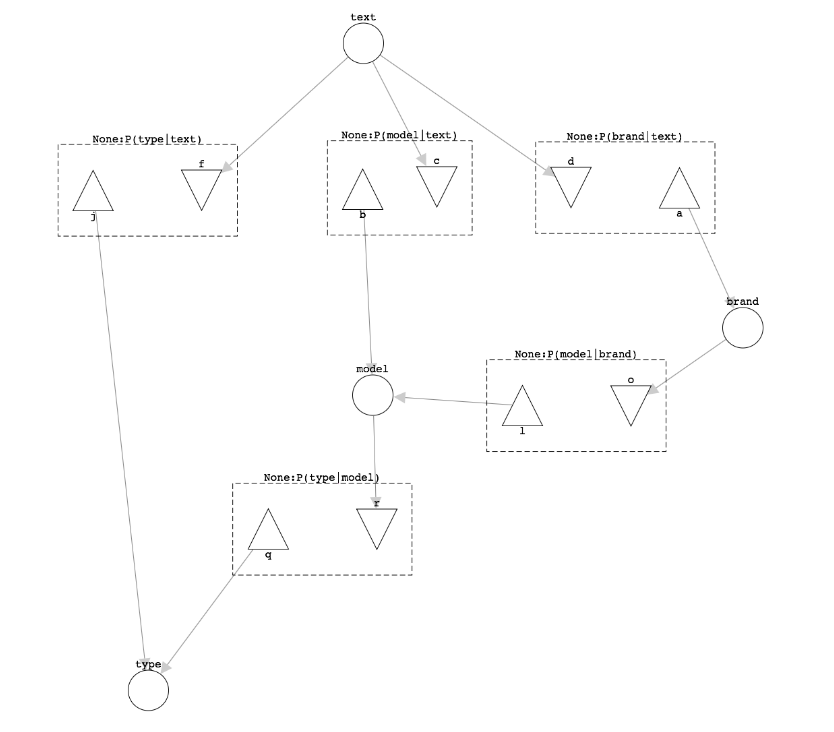

We will use a POS-style model to get our text-conditional probabilities for each desired attribute. Each word will recieve a part-of-speech distribution (part of speech here being BRAND, VARIANT, etc rather than VERB, NOUN, etc).

We can try to classify lexically - running a standard POS tagger and then creating our tagger model based on n-gram context.

When this task is done, we get $P(B|X)$, $P(M|X)$, and $P(T|X)$ from our POS model.
What else do we need to classify?

Lemma based on our independence assumptions:

$P(T|M,X) = p(T|M,X,B)$

This gives us
$P(B,M,T|X) 
    = P(T|M,B,X) \cdot P(B,M|X)
    = P(T|M,X) \cdot P(M|B,X) \cdot P(B|X)$

First run: naive. We assume that we can further factorize:

$P(B,M,T|X) = P(T|M,X) \cdot P(M|B,X) \cdot P(B|X)$

$P(B,M,T|X) = P(T|M)P(T|X) \cdot P(M|B)P(M|X) \cdot P(B|X)$




Given that our POS model will not include much signal from non-classified words, we are unlikely to find interactions between brand/text w.r.t. model, and model/text w.r.t type. If the structure of $P(M|X)$ was different, this assumption would be less valid. For examples, the word "connector" might be a signal that our type was an accessory, rather than a base instrument. 

We now just need P(T|M) and P(M|B). We will adaptively fit these distributions to data (MAP estimation). Each will be a categorical distribution with smoothing. The type of smoothing will depend on the data - we will have to see if instrument occurances on craigslist are zipf-regular?